# Illustrating of co-plotting `Split-Gal4` line, `hemibrain` skeleton with flywire dataset

## Step 1: Import neccesary library modules now

In [1]:
import navis
import fafbseg
import flybrains

In [2]:
import os
import numpy as np
import pandas as pd
import copy

In [3]:
import navis
import trimesh as tm
import open3d as o3d 
from vfb_connect.cross_server_tools import VfbConnect

In [4]:
from pyroglancer.localserver import startdataserver, closedataserver
from pyroglancer.flywire import flywireurl2dict, add_flywirelayer
from pyroglancer.utils import pointcloud2meshes

In [5]:
import navis.interfaces.neuprint as neu
from navis.interfaces.neuprint import NeuronCriteria as NC, SynapseCriteria as SC

## Step 2: Get the `Split-Gal4` line

Select the `Gal4` line you are interested in  for example, here I choose the line `R65G01` from the `neuronbridge` website [here](https://neuronbridge.janelia.org/search?q=R65G01)

## Step 3: Now convert the `Gal4` line to either a mesh ( a bit efficient) or to a skeleton (involves manual processing)

*Using a mesh object*: <br>
Go to the `virtualflybrain` site like [here](https://v2.virtualflybrain.org/org.geppetto.frontend/geppetto?id=VFB_00023647&i=VFB_00101567,VFB_00023647) and get the vfb id here: `VFB_00023647`

*Using a skeleton object*: <br>
1) Download the above line as *.nrrd* by following the link to the `virtualflybrain` site like [here](https://v2.virtualflybrain.org/org.geppetto.frontend/geppetto?id=VFB_00023647&i=VFB_00101567,VFB_00023647)  <br>
2) Use the *.nrrd* file in FiJi and skeletonise using the simple image tracer as illustrated in this video [here](https://youtu.be/xdqAb1fC91I) <br>
3) Save the skeletonised file as *.swc* format

The rest of the tutorial only involves the mesh object based co-visualisation

In [6]:
BASE_DIR = os.path.dirname(os.path.dirname(os.path.realpath("__file__")))
BASE_DIR

'/Users/sri/Documents/Python/pyroglancer/pyroglancer'

In [7]:
# vfb_neuron = navis.read_swc(swc_files, delimiter='\s+',units = 'um')
# swc_files = os.path.join(BASE_DIR, 'data/snt_tracings/VFB_00023647_snt_skel-000.swc')
# navis.health_check(vfb_neuron)
# vfb_neuron = navis.graph.clinic.merge_duplicate_nodes(vfb_neuron)

In [8]:
vc = VfbConnect()

In [9]:
vcinfo = vc.neo_query_wrapper.get_anatomical_individual_TermInfo(['VFB_00023647'])

In [10]:
image_folder = vcinfo[0]['channel_image'][0]['image']['image_folder'] + 'volume.obj'
image_folder

'http://www.virtualflybrain.org/data/VFB/i/0002/3647/volume.obj'

In [11]:
mesh_files = os.path.join(BASE_DIR, 'data/meshes/VFB_00023647.ply')
mesh_files

'/Users/sri/Documents/Python/pyroglancer/pyroglancer/data/meshes/VFB_00023647.ply'

In [12]:
vfb_mesh = pointcloud2meshes(mesh_files, algorithm='rollingball')

The mesh is not convex


In [13]:
jrc2018u_mesh = navis.Volume(flybrains.JRC2018U.mesh)

In [14]:
vfb_mesh.color = 'red'
vfb_mesh

<navis.Volume(name=None, color=red, vertices.shape=(13620, 3), faces.shape=(13508, 3))>

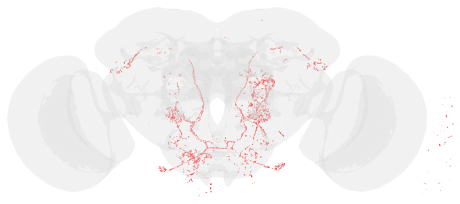

In [15]:
fig, ax = navis.plot2d([vfb_mesh,jrc2018u_mesh], method='2d')
fig.gca().invert_yaxis()

## Step 3: Set configurations to fetch from data from `neuprint`

In [16]:
neuprint_token = os.environ['NEUPRINT_APPLICATION_CREDENTIALS']
client = neu.Client('https://neuprint.janelia.org/', dataset='hemibrain:v1.1', token=neuprint_token)
client

Client("https://neuprint.janelia.org", "hemibrain:v1.1")

## Step 4: Get the matching skid from `neuprint` using the info from `neuronbridge` website like [here](https://neuronbridge.janelia.org/search/lines/R65G01/matches/2711776921103892491)

In [17]:
hemibrain_skel = neu.fetch_skeletons(1912789965, heal=1000, max_threads=30)

INFO - 2021-05-03 11:09:48,304 - utils - NumExpr defaulting to 8 threads.


## Step 5: Transform them to Flywire space..

In [18]:
#vfb_neuron=navis.xform_brain(vfb_neuron,source='JRC2018U', target='FLYWIRE')

In [19]:
vfbmesh_xyz = pd.DataFrame(list(map(np.ravel, vfb_mesh.vertices)), columns=['x', 'y', 'z'])

In [20]:
vfb2flywiremesh = copy.deepcopy(vfb_mesh)

In [21]:
vfb2flywiremesh_xyz = navis.xform_brain(vfbmesh_xyz[['x','y','z']],source='JRC2018U', target='FLYWIRE')

Transform path: JRC2018U -> JRC2018F -> FAFB14um -> FAFB14 -> FAFB14raw -> FLYWIREraw -> FLYWIRE


/Users/sri/Documents/Python/fafbseg-py/fafbseg/spine/base.py:416: UserWarning:

40 points failed to transform.



In [22]:
vfb2flywiremesh.vertices = vfb2flywiremesh_xyz

In [23]:
vfb2flywiremesh

<navis.Volume(name=None, color=(0.85, 0.85, 0.85, 0.2), vertices.shape=(13620, 3), faces.shape=(13508, 3))>

In [24]:
hemibrain2flywire_skel=navis.xform_brain(hemibrain_skel,source='JRCFIB2018Fraw', target='FLYWIRE')

Transform path: JRCFIB2018Fraw -> JRCFIB2018F -> JRCFIB2018Fum -> JRC2018F -> FAFB14um -> FAFB14 -> FAFB14raw -> FLYWIREraw -> FLYWIRE


## Step 6: Start the dataserver to host precomputed data..

In [25]:
startdataserver()

Serving data from:  /var/folders/_l/lrfvj_8j3ps0c37ncbr3c8dh0000gn/T/tmp1d4gmay0
Serving directory at http://127.0.0.1:8000


## Step 7: Get the url from flywire to append data onto..

In [26]:
shorturl = 'https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/5169621741076480'
#This flywire segments has some stuff similar (in blue), you will notice their closeness in the final plot

## Step 8: Add bodyids to flywire layers..

In [27]:
# vfb_neuron.id = 1234
# matchingneurons = navis.NeuronList(vfb_neuron)
# matchingneurons += hemibrain2flywire_skel

In [28]:
tmpviewer = add_flywirelayer(flywireurl2dict(shorturl), layer_kws = {'type': 'skeletons',
                                                                     'source': hemibrain2flywire_skel,
                                                                     'color': ['red'],
                                                                     #'space': 'FAFBv14.1',
                                                                     #'annotationstatetype': 'precomputed'
                                                                    }) 
#'alpha': 0.3, doesn't work yet in skeleton layers..

/private/var/folders/_l/lrfvj_8j3ps0c37ncbr3c8dh0000gn/T/tmp1d4gmay0/precomputed/skeletons/1912789965
creating: /private/var/folders/_l/lrfvj_8j3ps0c37ncbr3c8dh0000gn/T/tmp1d4gmay0/precomputed/skeletons/seg_props
{'1912789965': ['#ff0000']}
flywire url at: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/6731350031728640


In [29]:
shorturl = tmpviewer

In [30]:
vfb2flywiremesh.id = 1234

In [31]:
tmpviewer = add_flywirelayer(flywireurl2dict(shorturl), layer_kws = {'type': 'volumes','name': 'vfbneuron',
                                                        'source': vfb2flywiremesh,'color': 'magenta'})

mesh/1234
Seg id is: 1234
Full filepath: /private/var/folders/_l/lrfvj_8j3ps0c37ncbr3c8dh0000gn/T/tmp1d4gmay0/precomputed/vfbneuron/mesh/1234
creating: /private/var/folders/_l/lrfvj_8j3ps0c37ncbr3c8dh0000gn/T/tmp1d4gmay0/precomputed/vfbneuron/mesh/segment_properties
creating: /private/var/folders/_l/lrfvj_8j3ps0c37ncbr3c8dh0000gn/T/tmp1d4gmay0/precomputed/vfbneuron/mesh/segment_names
flywire url at: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/5370957002702848


127.0.0.1 - - [03/May/2021 11:10:08] "GET /precomputed/skeletons/info HTTP/1.1" 200 -
127.0.0.1 - - [03/May/2021 11:10:08] "GET /precomputed/vfbneuron/mesh/info HTTP/1.1" 200 -
127.0.0.1 - - [03/May/2021 11:10:08] "GET /precomputed/vfbneuron/mesh/1234:0 HTTP/1.1" 200 -
127.0.0.1 - - [03/May/2021 11:10:08] "GET /precomputed/skeletons/1912789965 HTTP/1.1" 200 -
127.0.0.1 - - [03/May/2021 11:10:08] "GET /precomputed/vfbneuron/mesh/1234 HTTP/1.1" 200 -


# Screenshot of the flywire instance should like below..

### The magenta neuron is the `gal4line` from `vfb` whereas the red neuron is the corresponding match from `hemibrain` according to `neuronbridge` and the green neuron is the corresponding `flywire` segment that is closest match

![alt text](pics/gal4line_hemibrain2flywire.png "Title")

## Step 9: Close the dataserver

In [32]:
closedataserver()

Closing server at http://127.0.0.1:8000
Cleaning directory at /private/var/folders/_l/lrfvj_8j3ps0c37ncbr3c8dh0000gn/T/tmp1d4gmay0
